# K-Means Clustering in Aviation Company

## Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data Preprocessing

We load the data from the source and display the first 5 rows.

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=14G4xOWK5e-QQ9S7GmBwULChNdeJZXs2U')
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


### Missing Values and Feature Selection

We will analyze the information of the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [ ]:
pro = df.isnull().sum()/len(df)
data_pro = {'Missing Values Total':[x for x in df.isnull().sum()], 'Percentage': [str(round(x*100,2))+'%' for x in pro]}
percentage = pd.DataFrame(data_pro, index=list(df.columns))
percentage

,Missing Values Total,Percentage
MEMBER_NO,0,0.0%
FFP_DATE,0,0.0%
FIRST_FLIGHT_DATE,0,0.0%
GENDER,3,0.0%
FFP_TIER,0,0.0%
WORK_CITY,2269,3.6%
WORK_PROVINCE,3248,5.16%
WORK_COUNTRY,26,0.04%
AGE,420,0.67%
LOAD_TIME,0,0.0%


We get that the columns gender, work_country, age, sum_yr_1, and sum_yr_2 has missing values total < 5 \%, so we decided to drop those missing values. Meanwhile, for the work_city, we see previously that there is some weird values, so we need to check it first. Moreover, for work_province, we should also analyze first before deciding what to do.

In [ ]:
df.dropna(subset=['GENDER', 'WORK_COUNTRY', 'AGE', 'SUM_YR_1', 'SUM_YR_2'], inplace = True)

city = df['WORK_CITY'].unique()
prov = df['WORK_PROVINCE'].unique()
country = df['WORK_COUNTRY'].unique()

print('Work city unique value =')
print(city)
print()
print('Work province unique value =')
print(prov)
print()
print('Work country unique value =')
print(country)

Work city unique value =
['.' nan 'Los Angeles' ... 'BELLREGUARD' 'Danville' 'lingshui']

Work province unique value =
['beijing' 'CA' 'guizhou' ... 'NOTARIO' 'TOPKPPI' 'JAWATIMUR']

Work country unique value =
['CN' 'US' 'FR' 'JP' 'HK' 'MY' 'AU' 'NL' 'MX' 'CA' 'KR' 'PK' 'TH' 'SG'
 'BR' 'PE' 'AE' 'HN' 'PH' 'ID' 'MO' 'GN' 'FL' 'KH' 'TW' 'VN' 'DE' 'IL'
 'CH' 'PA' 'VT' 'EC' 'NG' 'BI' 'GT' 'BE' 'GL' 'NZ' 'FA' 'NI' 'KO' 'AN'
 'CC' 'UV' 'MN' 'UK' 'AS' 'IT' 'OM' 'SE' 'BZ' 'IN' 'KZ' 'PT' 'NO' 'MS'
 'FI' 'UZ' 'NE' 'AT' 'AA' 'HU' 'CY' 'EG' 'MA' '中' 'ES' 'MZ' 'IR' 'SW' 'RE'
 'PS' 'KE' 'SN' 'BB' 'AZ' 'UA' 'LB' 'YE' 'GE' 'SI' 'KA' 'MV' 'RO' 'ZA'
 'DK' 'AB' 'CD' 'UY' 'CM' 'TK' 'AR' 'BN' 'PN' 'BD' '北' 'SU' 'RU' '沈' 'GU'
 'GB' 'ZW' 'PP' '芬' 'FO' 'IE' 'PR' 'BS' 'GH' 'SK' 'cn' 'TR' 'LA' 'BG' 'CL'
 'CR' 'SA']


We see that the unique values of work city, province and country are excessive and since our purpose is to cluster the customer based on their flight history, these columns are not relevant for this model. Thus, we decided to drop these columns.

In [ ]:
df = df.drop(['WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY'], axis = 1)
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,31.0,3/31/2014,210,505308,239560.0,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,42.0,3/31/2014,140,362480,171483.0,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,40.0,3/31/2014,135,351159,163618.0,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,64.0,3/31/2014,23,337314,116350.0,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,48.0,3/31/2014,152,273844,124560.0,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


The column member no is also not relevant for the model because it only explains the id of the customer. The first flight date and last flight date is also not relevant. Both columns is already represented by the column last to end, where we can obtain how long the customer book the flight after the last flight. The load time is also not relevant as it is the date time when the data is loaded. However, we can use this column and the FFP_date column to get an insight on how long the customer has been a frequent flyer program member.

In [ ]:
# Change the column data type to datetime
df['FFP_DATE'] = pd.to_datetime(df['FFP_DATE'])
df['LOAD_TIME'] = pd.to_datetime(df['LOAD_TIME'])

# Get the FFP member duration in year
df['FFP_DURATION'] = df['LOAD_TIME'].dt.year.max() - df['FFP_DATE'].dt.year

# Delete the unused columns
df = df.drop(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME', 'LAST_FLIGHT_DATE'], axis=1)

df.head()

,GENDER,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,FFP_DURATION
0,Male,6,31.0,210,505308,239560.0,234188.0,580717,1,3.483254,18,34,0.961639,619760,50,8
1,Male,6,42.0,140,362480,171483.0,167434.0,293678,7,5.194245,17,29,1.252314,415768,33,7
2,Male,6,40.0,135,351159,163618.0,164982.0,283712,11,5.298507,18,20,1.254676,406361,26,7
3,Male,5,64.0,23,337314,116350.0,125500.0,281336,97,27.863636,73,11,1.090870,372204,12,6
4,Male,6,48.0,152,273844,124560.0,130702.0,309928,5,4.788079,47,27,0.970658,338813,39,5


### Duplicated Values

Now let us check if there exist duplicated values and delete it.

In [ ]:
df.duplicated().sum()

1

In [ ]:
df = df.drop_duplicates()

### Encoding Categorical Data

Next, we encode the column gender. Because it only has 2 values, we can just replace it 1 and 0 where 1 is male and 0 is female.

In [ ]:
df['GENDER'] = df['GENDER'].map({'Male': 1, 'Female': 0})
df.head()

,GENDER,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,FFP_DURATION
0,1,6,31.0,210,505308,239560.0,234188.0,580717,1,3.483254,18,34,0.961639,619760,50,8
1,1,6,42.0,140,362480,171483.0,167434.0,293678,7,5.194245,17,29,1.252314,415768,33,7
2,1,6,40.0,135,351159,163618.0,164982.0,283712,11,5.298507,18,20,1.254676,406361,26,7
3,1,5,64.0,23,337314,116350.0,125500.0,281336,97,27.863636,73,11,1.090870,372204,12,6
4,1,6,48.0,152,273844,124560.0,130702.0,309928,5,4.788079,47,27,0.970658,338813,39,5


### Outliers

We now check the outliers of each columns.

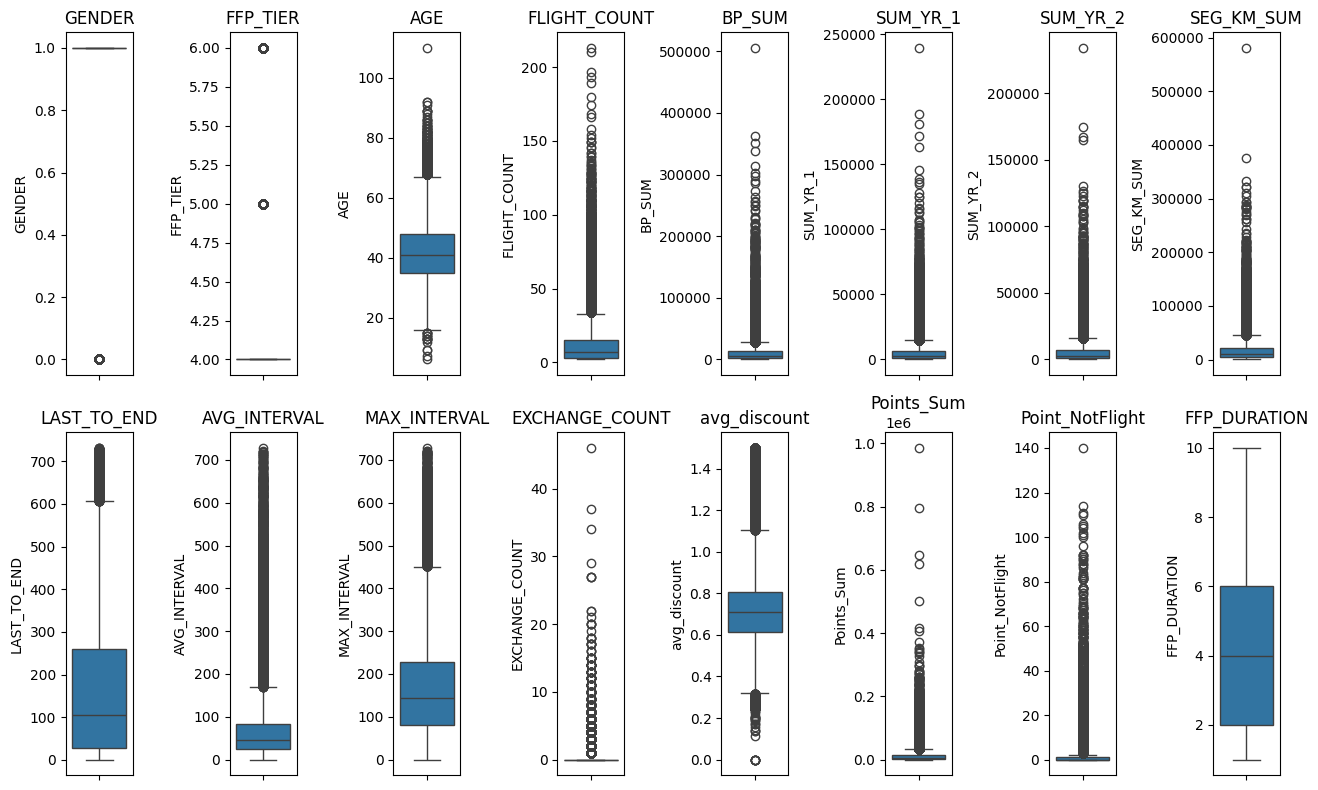

In [ ]:
cols = df.columns
n = len(cols)
fig, axes = plt.subplots(2, 8, figsize=(13, 8))

for i in range(n):
  ax = axes[i // 8, i % 8]
  sns.boxplot(y=df[cols[i]], ax=ax)
  ax.set_title(cols[i])

plt.tight_layout()
plt.show()

In [ ]:
df['FFP_TIER'].unique()

array([6, 5, 4])

We see that ffp tier and gender are actually categorical, so we let them be. On the other hand, other columns aside from ffp duration has a lot of outliers. Thus, we will try to do logarithmic transformations with a small constant values to avoid log 0 which will yield infinity.

In [ ]:
cols = ['AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
        'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL', 'EXCHANGE_COUNT', 'avg_discount',
        'Points_Sum', 'Point_NotFlight']

for x in cols:
  df[x] = np.log(df[x] + 1)

### Scaling

After transformation, we will normalize the values of the numerical columns since their range varies. We will implement the minmaxscaler for the scaling process.

In [ ]:
cols = ['AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
        'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL', 'EXCHANGE_COUNT', 'avg_discount',
        'Points_Sum', 'Point_NotFlight', 'FFP_DURATION']

scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])
df.head()

,GENDER,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,FFP_DURATION
0,1,6,0.549940,0.996692,1.000000,1.000000,1.000000,1.000000,0.000000,0.227613,0.446691,0.923432,0.735335,0.966387,0.794507,0.777778
1,1,6,0.656852,0.902231,0.974705,0.973010,0.972862,0.907383,0.234860,0.276655,0.438488,0.883394,0.886136,0.937461,0.712575,0.666667
2,1,6,0.639618,0.893770,0.972289,0.969219,0.971669,0.902693,0.303553,0.279187,0.446691,0.790755,0.887280,0.935803,0.665992,0.666667
3,1,5,0.806362,0.487290,0.969226,0.941695,0.949545,0.901550,0.659336,0.510126,0.652955,0.645406,0.804963,0.929441,0.518301,0.555556
4,1,6,0.704116,0.921371,0.953353,0.947200,0.952830,0.914699,0.186122,0.266366,0.587287,0.865474,0.740341,0.922631,0.745415,0.444444


## Modeling

We will do clustering using K-Means. Firstly, we will check the result for some k, calculate the silhouette score, and visualize them both.

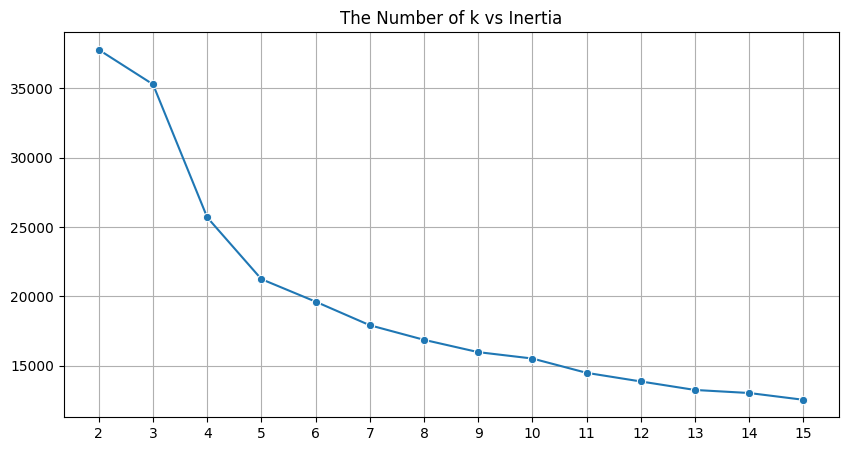

In [ ]:
inertia = []
arr_silhouette_score_euclidean = []

for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df.values)
    inertia.append(kmeans.inertia_)

    preds = kmeans.predict(df)
    score_euclidean = silhouette_score(df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

plt.figure(figsize=(10, 5))

k = [i for i in range(2, 16)]
sns.lineplot(x=k, y=inertia, marker='o')

plt.xticks(k)
plt.grid()
plt.title('The Number of k vs Inertia')

plt.show()

Now we visualize the silhouette score.

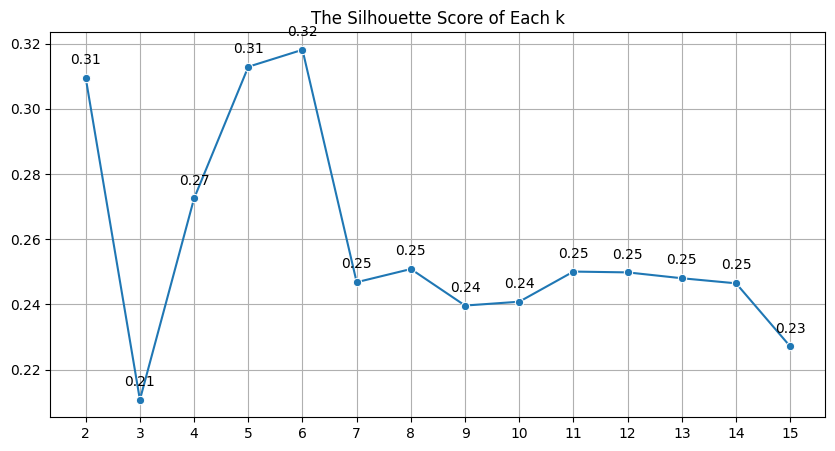

In [ ]:
plt.figure(figsize=(10, 5))

k = [i for i in range(2, 16)]
sns.lineplot(x=k, y=arr_silhouette_score_euclidean, marker='o')

for i in range(len(k)):
    plt.annotate(round(arr_silhouette_score_euclidean[i],2), (k[i], arr_silhouette_score_euclidean[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(k)
plt.grid()
plt.title('The Silhouette Score of Each k')

plt.show()

Based on the elbow method and silhouette score above, we obtain that the best number of cluster is 6.

## Visualization

For visualization purposes, we will reduce the data into two features by using PCA. Then, we apply the k means clustering with k=6 and visualize it using scatter plot.

In [ ]:
pca = PCA(n_components=2)
pca.fit(df)
pcs = pca.transform(df)

cols = ['pc1', 'pc2']
pdf = pd.DataFrame(data = pcs, columns = cols)

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(df)

pdf['Cluster'] = kmeans.labels_
pdf.head()

,pc1,pc2,Cluster
0,2.302623,-0.850144,2
1,2.131624,-0.773469,2
2,2.087183,-0.752753,2
3,1.216658,-0.313419,5
4,2.112457,-0.776893,2


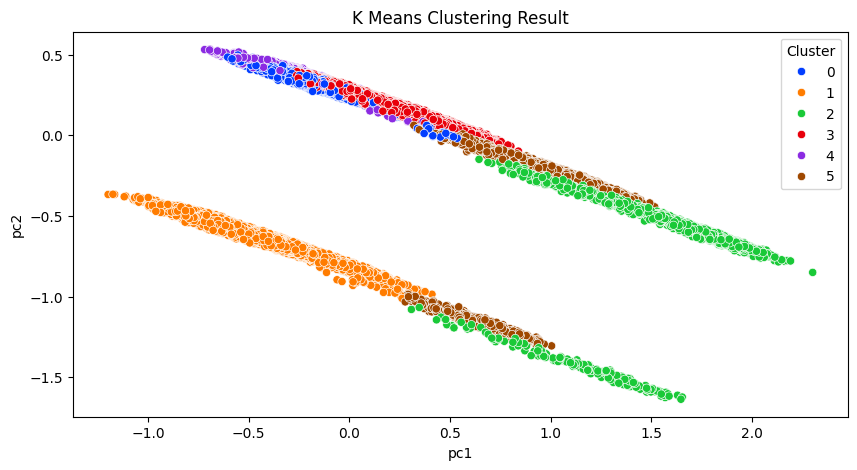

In [ ]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=pdf, x='pc1', y='pc2', hue='Cluster', palette='bright')

plt.title('K Means Clustering Result')
plt.show()

## Insight

For better interpretation, we undo the scaling and the log transformation. Then, we save the cluster result to the new column Cluster for grouping.

In [ ]:
cols = ['AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
        'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL', 'EXCHANGE_COUNT', 'avg_discount',
        'Points_Sum', 'Point_NotFlight', 'FFP_DURATION']

df[cols] = scaler.inverse_transform(df[cols])

cols = ['AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
        'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL', 'EXCHANGE_COUNT', 'avg_discount',
        'Points_Sum', 'Point_NotFlight']

for x in cols:
  df[x] = np.exp(df[x]) - 1

df['Cluster'] = kmeans.labels_
df.head()

,GENDER,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,FFP_DURATION,Cluster
0,1,6,31.0,210.0,505308.0,239560.0,234188.0,580717.0,1.0,3.483254,18.0,34.0,0.961639,619760.0,50.0,8.0,2
1,1,6,42.0,140.0,362480.0,171483.0,167434.0,293678.0,7.0,5.194245,17.0,29.0,1.252314,415768.0,33.0,7.0,2
2,1,6,40.0,135.0,351159.0,163618.0,164982.0,283712.0,11.0,5.298507,18.0,20.0,1.254676,406361.0,26.0,7.0,2
3,1,5,64.0,23.0,337314.0,116350.0,125500.0,281336.0,97.0,27.863636,73.0,11.0,1.090870,372204.0,12.0,6.0,5
4,1,6,48.0,152.0,273844.0,124560.0,130702.0,309928.0,5.0,4.788079,47.0,27.0,0.970658,338813.0,39.0,5.0,2


We grouped the data based on the cluster and set aggregate function for each column.

In [ ]:
df.groupby('Cluster').agg({'GENDER': [lambda x: x.mode()[0]],
                           'FFP_TIER' : [lambda x: x.mode()[0]],
                           'AGE' : ['mean'],
                           'FLIGHT_COUNT' : ['mean'],
                           'BP_SUM' : ['mean'],
                           'SUM_YR_1' : ['mean'],
                           'SUM_YR_2' : ['mean'],
                           'SEG_KM_SUM' : ['mean'],
                           'LAST_TO_END' : ['mean'],
                           'AVG_INTERVAL' : ['mean'],
                           'MAX_INTERVAL' : ['mean'],
                           'EXCHANGE_COUNT' : ['mean'],
                           'avg_discount' : ['mean'],
                           'Points_Sum' : ['mean'],
                           'Point_NotFlight' : ['mean'],
                           'FFP_DURATION' : ['mean'],
})

,GENDER,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,FFP_DURATION
,<lambda>,<lambda>,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Cluster,,,,,,,,,,,,,,,,
0,1,4,41.920537,4.600177,3995.701165,1.885301,3595.379478,6940.715465,111.004275,65.677617,115.131210,0.063099,0.689475,4882.419873,1.979655,4.269940
1,0,4,39.708026,8.086280,7311.537044,3736.151689,3578.678620,12814.513591,204.247723,74.023901,170.775371,0.189414,0.686121,8460.226924,2.530804,3.914653
2,1,6,47.096667,46.096667,56254.159333,23246.071333,30104.294667,64515.417333,46.320667,28.418707,106.458667,2.180000,0.959324,68797.033333,9.525333,5.484000
3,1,4,43.453397,12.867036,11157.584139,5789.055175,5674.308862,18539.655225,106.174910,78.987727,211.942214,0.302794,0.720488,12478.866965,2.636809,4.462676
4,1,4,43.056241,4.083417,3734.874308,3665.025074,10.996855,6225.791268,492.137267,47.423735,83.484776,0.061147,0.726422,4253.195647,1.349270,3.935455
5,1,5,43.690555,38.917241,37059.591304,15672.788306,20947.804498,51816.255172,25.425187,23.880087,109.595202,1.392804,0.827242,42768.187706,6.661769,5.197301


We obtain from the table that:
1. Cluster 0 is mostly a male customer whose number of flight is the second lowest which can be shown by the columns from flight count to max interval. They seldom do exchange and only have 0.69 discount in average. Their points are also the second lowest but they have been in the frequent flyer program for around 4 years.
2. Cluster 1 is mostly a female customer whose number of flight is the third lowest. They seldom do exchange and only have 0.69 discount in average. Their points are also the third lowest and they are some of the newest member of frequent flyer program.
3. Cluster 2 is mostly a male customer who has the most frequent flight. They always do exchange and achieve the highest discount. Their points are also the highest and they are some of the oldest member of frequent flyer program.
4. Cluster 3 is mostly a male customer who have medium number of flight. They do exchange more than cluster 0, 1, and 4. They achieve medium discount level at 0.72. Their points are also medium and they have been in the frequent flyer program for around 4 years.
5. Cluster 4 is mostly a male customer who has the lowest number of flight.They seldom do exchange but achieve higher discount than cluster 0 and 1 at around 0.72 in average. Their points are also the lowest and they are some of the newest member of frequent flyer program.
6. Cluster 5 is mostly a male customer who has the second highest number of flight. They always do exchange but still lower than cluster 2 and achieve the second highest discount. Their points are also the second highest and they are some of the oldest member of frequent flyer program.